Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

In [15]:
from matplotlib import pyplot as plt
import numpy as np
import napari
from sklearn.model_selection import train_test_split

from glob import glob
from tqdm import tqdm
from csbdeep.utils import normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents
from stardist import Rays_GoldenSpiral
from stardist.matching import matching_dataset
from stardist.models import Config3D, StarDist3D

from utils_training_stardist import process_images, fix_overlapping_labels, ignore_xy_border_labels, plot_img_label, augmenter

lbl_cmap = random_label_cmap()

<h3>Data loading and normalization</h3>

In [16]:
# Point to the disk location where your images and ground truth labels (masks) are located
X = sorted(glob('../training_data/organoid_Nikon_nihanseb/images/*.tif'))
Y = sorted(glob('../training_data/organoid_Nikon_nihanseb/masks/*.tif'))

# Set a slicing factor for training a model using compressed versions of your images (i.e. 2 or 4)
slicing_factor = 2

# Did you allow overlapping labels in Labkit? Set fix labels to True if you need to get rid of overlapping nuclei labels. False by default.
fix_labels = True

# Ignore labels touching the edge of the annotated image during training?
ignore_on_edges = False

In [17]:
# Training data is provided via a list of Numpy arrays, it consists of pairs of input images (X) and label (Y) instances
X = process_images(X, slicing_factor)
Y = process_images(Y, slicing_factor)

# Normalize images and fill small label holes if present
axis_norm = (0,1,2)   # normalize channels independently
print("Normalizing input images...")
X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
print("\nFilling label holes...")
Y = [fill_label_holes(y) for y in tqdm(Y)]

# Remove overlapping labels if present
if fix_labels:
    print("\nFixing overlapping labels...")
    Y = [fix_overlapping_labels(y) for y in tqdm(Y)]

# Ignore labels on edges during training
if ignore_on_edges:
    print("\nRemoving (ignoring) xy edge touching labels...")
    Y = [ignore_xy_border_labels(y) for y in tqdm(Y)]


# Perform an 80/20 training/validation split 
X_trn, X_val, Y_trn, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"\nNumber of images: {len(X)}")
print(f"- Training: {len(X_trn)}")
print(f"- Validation: {len(X_val)}")
print(f"\nSlicing factor applied: {slicing_factor}")

Normalizing input images...


100%|██████████| 24/24 [00:00<00:00, 315.61it/s]



Filling label holes...


100%|██████████| 24/24 [00:00<00:00, 371.93it/s]



Fixing overlapping labels...


100%|██████████| 24/24 [00:05<00:00,  4.70it/s]


Number of images: 24
- Training: 19
- Validation: 5

Slicing factor applied: 2


<h3>Image and ground truth visualization</h3>

In [9]:
# Explore individual image/label pairs in Napari by setting an index value
index = 0

viewer = napari.Viewer(ndisplay=2)
viewer.add_image(X_trn[index])
viewer.add_labels(Y_trn[index])

<Labels layer 'Labels' at 0x2c588547280>

<h3>Model Configuration</h3>

In [10]:
# Close the previous Napari viewer
viewer.close()

# Calculate Anisotropy
extents = calculate_extents(Y)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))

empirical anisotropy of labeled objects = (2.5, 1.015625, 1.0)


In [11]:
# 96 is a good default choice (see 1_data.ipynb)
n_rays = 96

# Use OpenCL-based computations for data generator during training (requires 'gputools') - Not implemented
use_gpu = False

# Predict on subsampled grid for increased efficiency and larger field of view
grid = tuple(1 if a > 1.5 else 2 for a in anisotropy)

# Use rays on a Fibonacci lattice adjusted for measured anisotropy of the training data
rays = Rays_GoldenSpiral(n_rays, anisotropy=anisotropy)

conf = Config3D (
    rays             = rays,
    grid             = grid, # You might need to manually adjust if the object size is larger than the FOV of the network (i.e. (1, 4, 4))
    anisotropy       = anisotropy,
    use_gpu          = use_gpu,
    n_channel_in     = 1,
    train_patch_size = (20,64,64), # Adjust for your data (make patch size as large as possible)
    train_batch_size = 2,
    train_epochs=300,
)
print(conf)
vars(conf)

Config3D(n_dim=3, axes='ZYXC', n_channel_in=1, n_channel_out=97, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=96, grid=(1, 2, 2), anisotropy=(2.5, 1.015625, 1.0), backbone='unet', rays_json={'name': 'Rays_GoldenSpiral', 'kwargs': {'n': 96, 'anisotropy': (2.5, 1.015625, 1.0)}}, n_classes=None, unet_n_depth=2, unet_kernel_size=(3, 3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, None, 1), net_mask_shape=(None, None, None, 1), train_patch_size=(20, 64, 64), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=300, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=2, train_n_val_patc

{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 97,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 96,
 'grid': (1, 2, 2),
 'anisotropy': (2.5, 1.015625, 1.0),
 'backbone': 'unet',
 'rays_json': {'name': 'Rays_GoldenSpiral',
  'kwargs': {'n': 96, 'anisotropy': (2.5, 1.015625, 1.0)}},
 'n_classes': None,
 'unet_n_depth': 2,
 'unet_kernel_size': (3, 3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, None, 1),
 'net_mask_shape': (None, None, None, 1),
 'train_patch_size': (20, 64, 64),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_we

In [ ]:
model = StarDist3D(conf, name=f'3D_org_nihanseb_sf_{slicing_factor}', basedir='../3D_Stardist/stardist_models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [13]:
# Check if the neural network has a large enough field of view to see up to the boundary of most objects.

median_size = calculate_extents(Y, np.median)
fov = np.array(model._axes_tile_overlap('ZYX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network. Increase the grid parameter")

median object size:      [ 6.5  16.   16.25]
network field of view :  [26 46 46]


<h3>Data Augmentation and Training</h3>

You can define a function/callable that applies augmentation to each batch of the data generator (see <code>utils_training_stardist.py</code>).
We here use an <code>augmenter</code> that applies random rotations, flips, and intensity changes, which are typically sensible for (3D) microscopy images (but you can disable augmentation by setting <code>augmenter = None</code>).

You can monitor the progress during training in a separate JN by launching a Tensorboard instance.

In [ ]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)

<h3>Threshold optimization</h3>

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [10]:
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|███████▌  | 15/20 [01:10<00:23,  4.68s/it, 0.492 -> 0.539]


Using optimized values: prob_thresh=0.491853, nms_thresh=0.4.
Saving to 'thresholds.json'.


{'prob': 0.4918530994110567, 'nms': 0.4}

<h3>Evaluation and Detection Performance</h3>

Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.

The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). 
The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see `help(matching)` for definitions of the abbreviations used in the evaluation below and see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for further details.

In [11]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


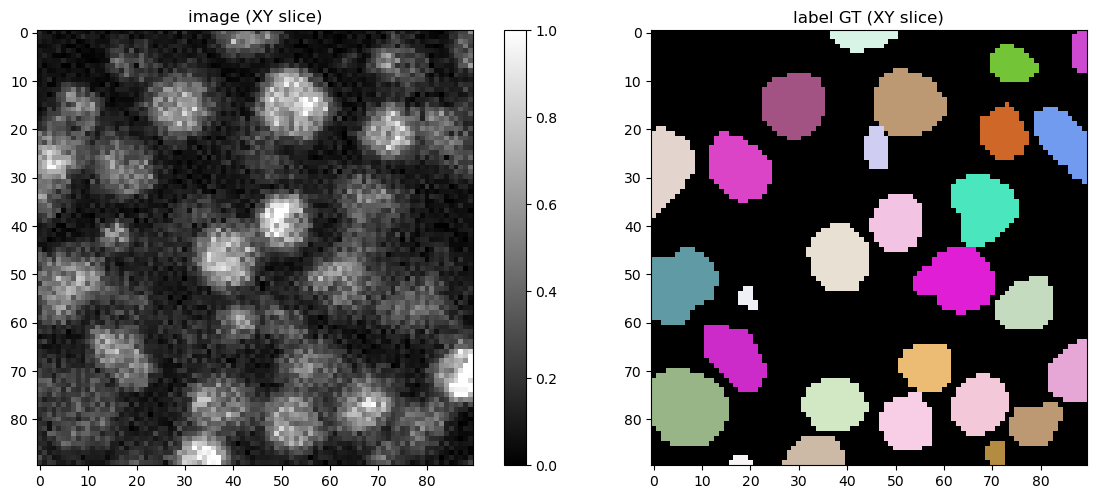

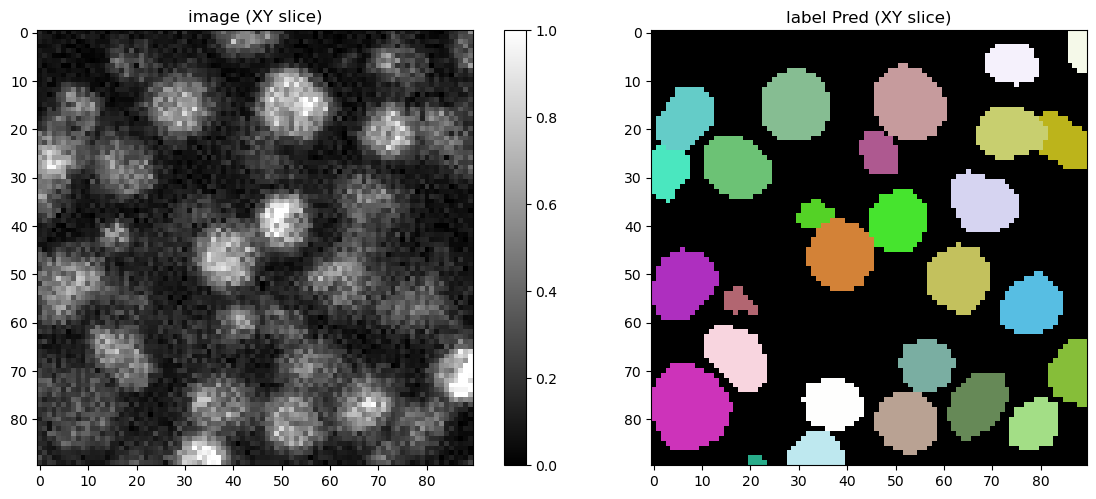

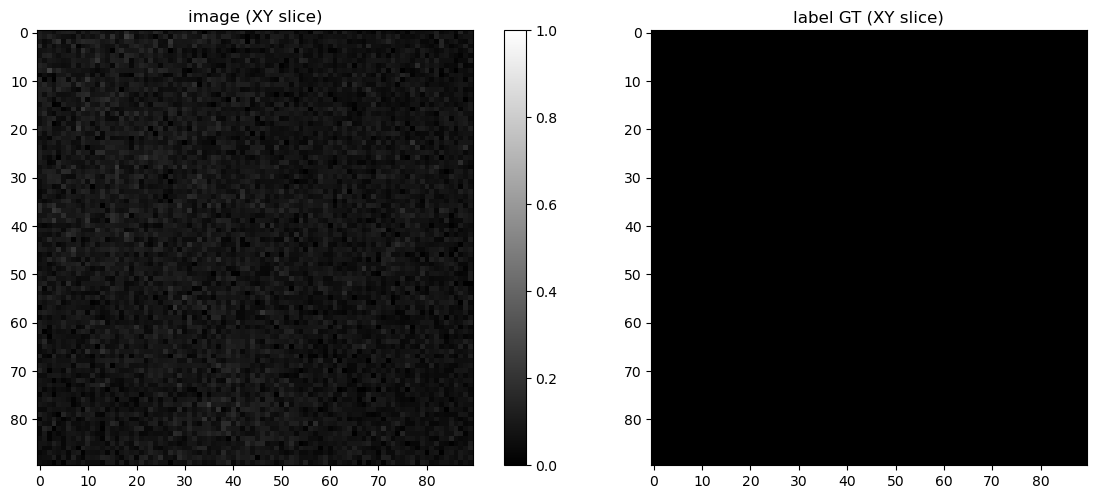

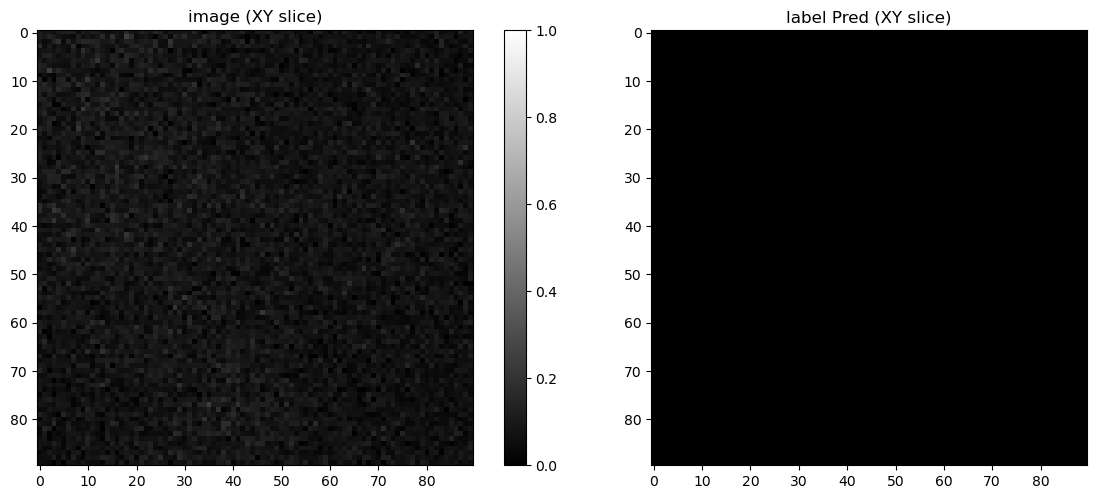

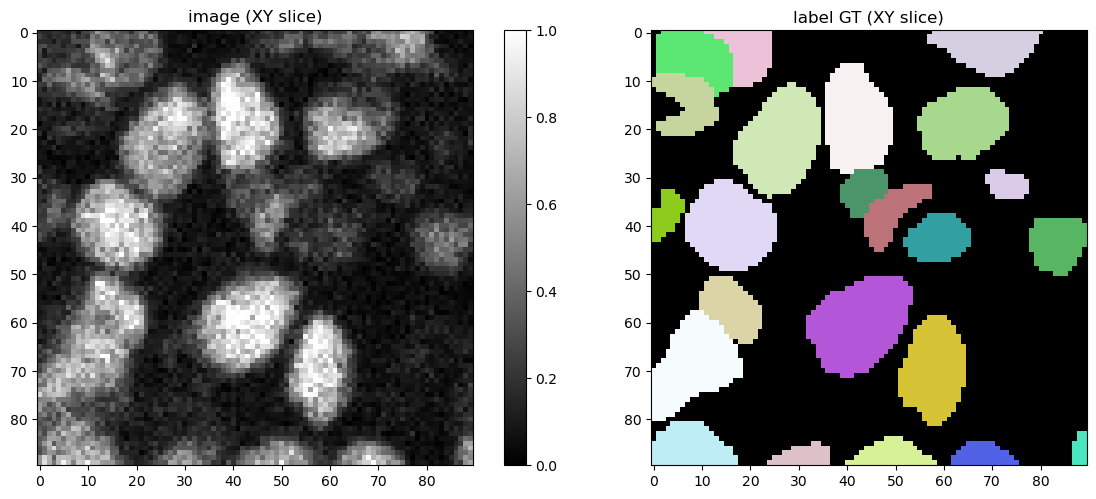

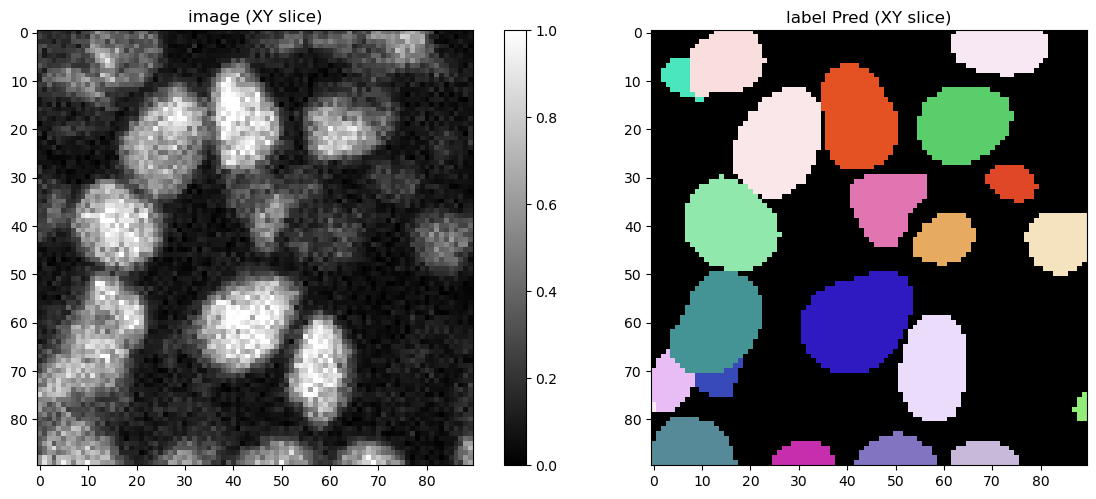

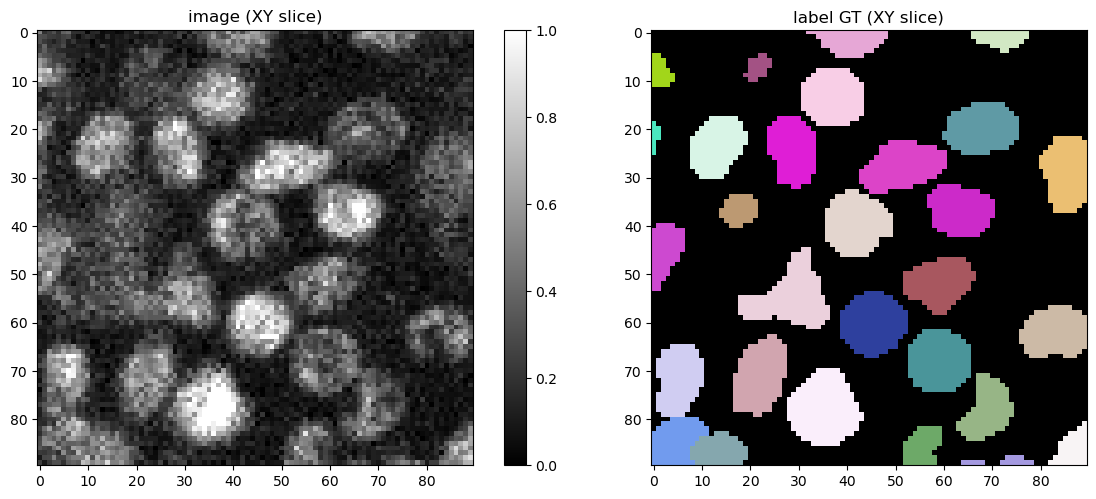

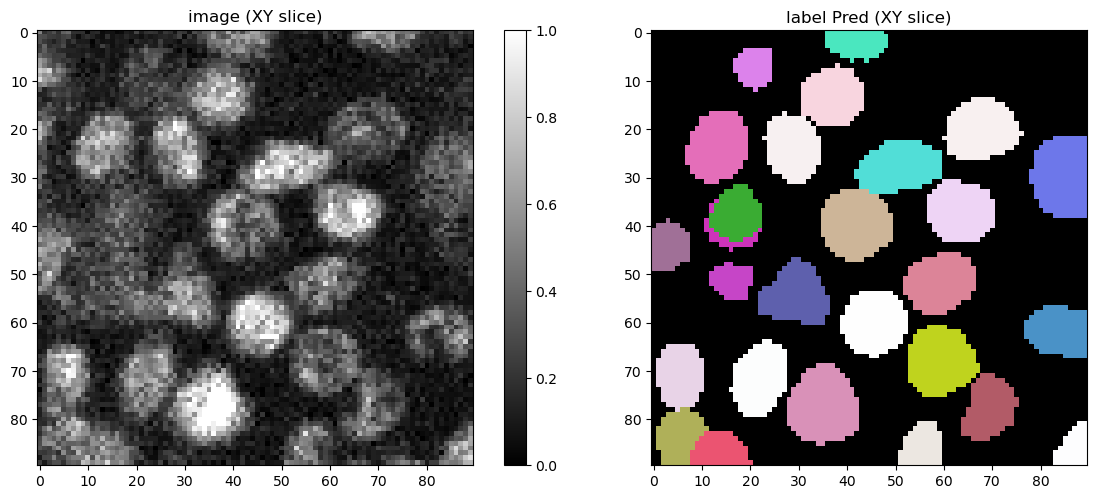

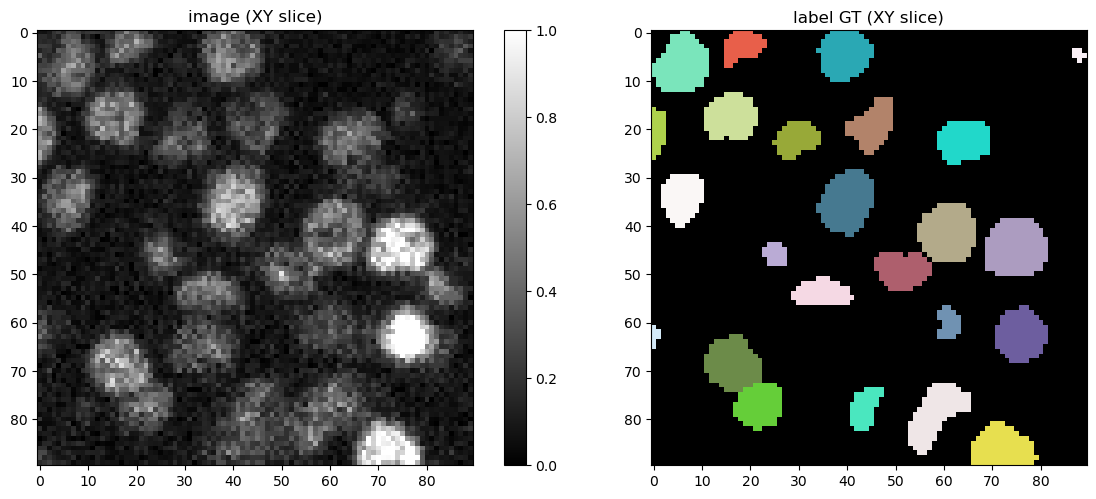

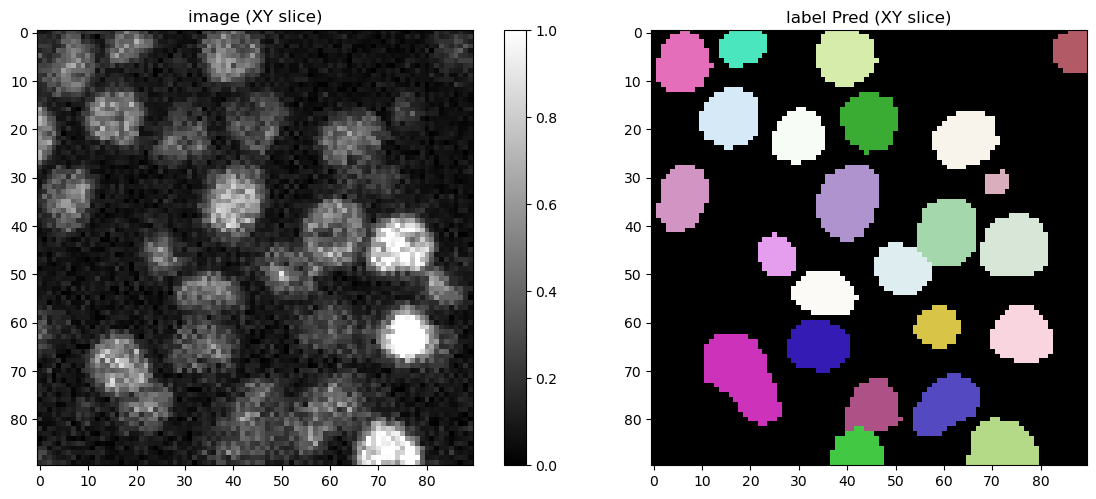

In [12]:
for index in range(0,len(X_val)):
    # Plot a Ground Truth (GT) / Prediction example
    plot_img_label(X_val[index],Y_val[index], lbl_title="label GT (XY slice)")
    plot_img_label(X_val[index],Y_val_pred[index], lbl_title="label Pred (XY slice)")

In [13]:
# Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:00<00:00, 58.24it/s]


In [14]:
# Example: Print all available matching statistics for tau=0.7
stats[taus.index(0.7)]

DatasetMatching(criterion='iou', thresh=0.7, fp=62, tp=61, fn=73, precision=0.4959349593495935, recall=0.4552238805970149, accuracy=0.3112244897959184, f1=0.47470817120622566, n_true=134, n_pred=123, mean_true_score=0.3551641115501745, mean_matched_score=0.7801965729134982, panoptic_quality=0.3703656883091314, by_image=False)

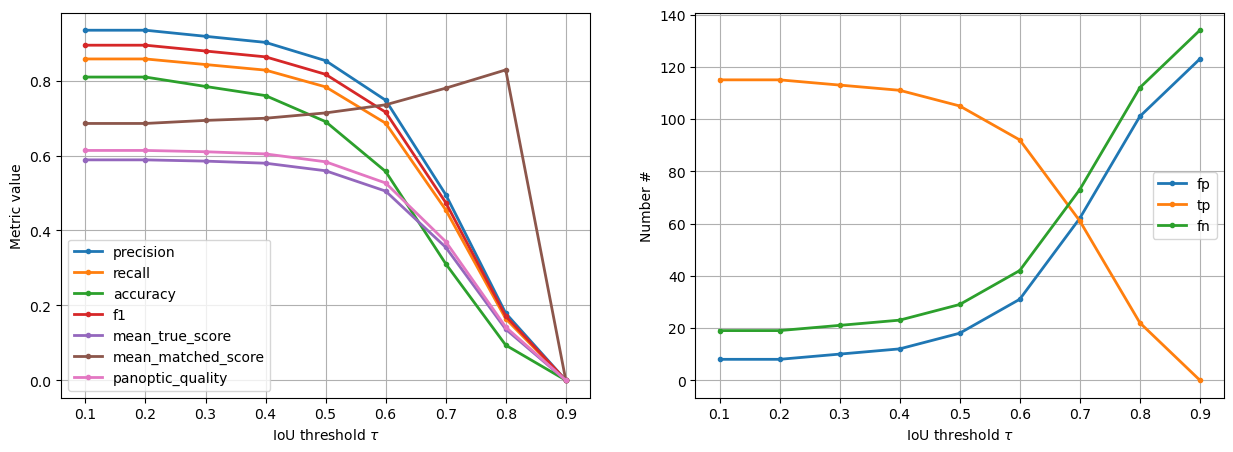

In [15]:
# Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();